In [1]:
from imports import *

/Users/abarnes/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.25.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [30]:
def plot_median_with_percentile_error(ax, data, y=0.07, color1='C0', color2='C0', marker='s',
                                      error_linewidth=2, capsize=5, capthick=2, scatter_linewidth=1.75):
    """
    Plot the median of `data` with error bars representing the 16th and 84th percentiles on a given axis.
    
    Parameters:
    -----------
    ax : matplotlib.axes.Axes
        The axes on which to plot.
    data : array-like
        The data from which to compute the median and percentile ranges.
    y : float, optional
        The y-coordinate at which to plot the marker and error bar (default is 0.07).
    color1 : str, optional
        Color for the error bars and marker edge (default is 'C0').
    color2 : str, optional
        Color for the marker face (default is 'C0').
    marker : str, optional
        Marker style for the median point (default is 's').
    error_linewidth : float, optional
        Line width for the error bar (default is 2).
    capsize : float, optional
        The length of the error bar caps in points (default is 5).
    capthick : float, optional
        The thickness of the error bar caps (default is 2).
    scatter_linewidth : float, optional
        The line width for the scatter marker edge (default is 1.75).
    """
    # Compute the median and the 16th and 84th percentiles
    median = np.nanmedian(data)
    p16, p84 = np.nanpercentile(data, [16, 84])
    err_low = median - p16  # Distance from median to 16th percentile
    err_high = p84 - median  # Distance from median to 84th percentile

    # Plot the median with asymmetric error bars representing the 16th and 84th percentiles
    ax.errorbar(median, y, xerr=[[err_low], [err_high]], elinewidth=error_linewidth, 
                capsize=capsize, capthick=capthick, zorder=5, color=color1)
    ax.scatter([median], [y], marker=marker, ec=color1, fc=color2, 
               zorder=5, linewidths=scatter_linewidth)
    
    return

In [2]:
root_dir = '/Users/abarnes/Dropbox/work/Smallprojects/galaxies'
# table = QTable.read('%s/data_hstha_nebulae_catalogue/all/nebulae_catalogue.fits' %root_dir)
table = QTable.read('%s/data_hstha_nebulae_catalogue/all/nebulae_catalogue_fixediso_10pc.fits' %root_dir)
table_muse_masked = QTable.read('%s/data_misc/Nebulae_catalogue_v3/Nebulae_catalogue_v3_HSTFOV.fits' %root_dir)

table = table[(table['flag_star_MUSE']!=1) & (table['flag_edge_MUSE']!=1) & (table["flag_edge_hst"]!=1)] # remove stars and edge objects
table_muse_masked = table_muse_masked[(table_muse_masked['flag_star']!=1) & (table_muse_masked['flag_edge']!=1)] # remove stars and edge objects

print(f'Table length post-masking (inc. stars etc): {len(table)}')
print(f'Table MUSE with HST FOV length post-masking (inc. stars etc): {len(table_muse_masked)}')
# table

Table length post-masking (inc. stars etc): 5559
Table MUSE with HST FOV length post-masking (inc. stars etc): 25910


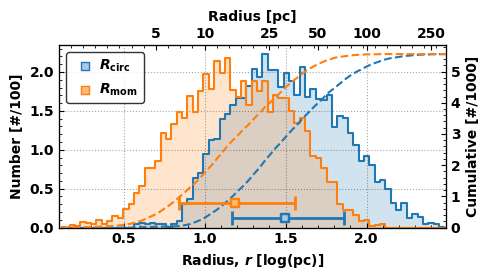

In [33]:
colors = mpl.cm.tab20(np.arange(0,20))
colors1 = colors[::2]
colors2 = colors[1::2]

data1 = np.log10(table['radius_circ_pc'].value)
data2 = np.log10(table['mean_sigma_pc'].value)

bins = np.linspace(0.1, np.nanmax([data1,data2]), 75)

bins1, bins_cent1, hist1 = get_hist(data1, bins=bins, norm=False)
bins2, bins_cent2, hist2 = get_hist(data2, bins=bins, norm=False)

fig = plt.figure(figsize=(5, 2.9)) 
ax = fig.add_subplot(111)

ax.plot(bins_cent1, hist1/100, ds='steps-mid', c='C0')
ax.fill_between(bins_cent1, hist1/100, alpha=0.2, step='mid', fc='C0')
ax.scatter(np.nan, np.nan, marker='s', ec=colors1[0], fc=colors2[0], label='$R_\mathrm{circ}$')

ax.plot(bins_cent2, hist2/100, ds='steps-mid', c='C1')
ax.fill_between(bins_cent2, hist2/100, alpha=0.2, step='mid', fc='C1')
ax.scatter(np.nan, np.nan, marker='s', ec=colors1[1], fc=colors2[1], label='$R_\mathrm{mom}$')

ylim = ax.get_ylim()
ax.set_ylim(0, ylim[-1])
ax.set_xlim(0.1, 2.49)

ax.grid(True, alpha=0.35, ls=':', color='black')

ax.set_xlabel('Radius, $r$ [log(pc)]')
ax.set_ylabel('Number [#/100]')

ax2 = ax.twiny()
ax2.set_xlim(ax.get_xlim())
new_tick_locations = np.log10([5,10,25,50,100,250])
ax2.set_xticks(new_tick_locations)
ax2.set_xticklabels(np.round(np.power(10, new_tick_locations)).astype(int))
ax2.set_xlabel('Radius [pc]')
ax.legend(loc='upper left', edgecolor='black', handletextpad=0)

ax2 = ax.twinx()
running_sum = np.cumsum(hist1)
ax2.plot(bins_cent1, running_sum/1000, ls='--', c='C0')
running_sum = np.cumsum(hist2)
ax2.plot(bins_cent2, running_sum/1000, ls='--', c='C1')

# plot medians
plot_median_with_percentile_error(ax2, data1, y=0.3, color1=colors1[0], color2=colors2[0])
plot_median_with_percentile_error(ax2, data2, y=0.8, color1=colors1[1], color2=colors2[1])

ylim = ax2.get_ylim()
ax2.set_ylim(0, ylim[-1])
ax2.set_ylabel('Cumulative [#/1000]')

fig.tight_layout(h_pad=0.5, w_pad=0.5)

plt.savefig('./figs/hist_radlog_sigma_all.pdf', dpi=250, bbox_inches='tight')

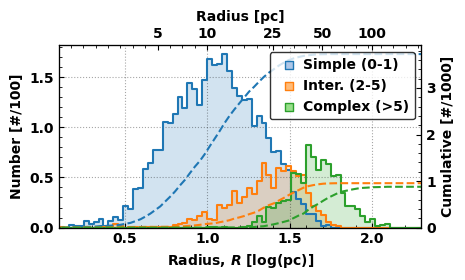

In [4]:
fig = plt.figure(figsize=(5, 2.9)) 
ax = fig.add_subplot(111)
ax2 = ax.twinx()

data1 = np.log10(table['mean_sigma_pc'].value)
bins = np.linspace(np.nanmin([data1])*0.9, np.nanmax([data1])*1.1, 75)

for complexity_score in zip([0, 2, 5], [2, 5, 500]):

    data1 = np.log10(table['mean_sigma_pc'].value)
    mask = (table['complexity_score'] >= complexity_score[0]) & (table['complexity_score'] < complexity_score[1])
    data1 = data1[mask]
    bins1, bins_cent1, hist1 = get_hist(data1, bins=bins, norm=False)

    ax.plot(bins_cent1, hist1/100, ds='steps-mid')
    ax.fill_between(bins_cent1, hist1/100, alpha=0.2, step='mid')

    running_sum = np.cumsum(hist1)
    ax2.plot(bins_cent1, running_sum/1000, ls='--')

ylim = ax2.get_ylim()
ax2.set_ylim(0, ylim[-1])
ax2.set_ylabel('Cumulative [#/1000]')

ylim = ax.get_ylim()
ax.set_ylim(0, ylim[-1])
ax.set_xlim(0.1, 2.3)

ax.grid(True, alpha=0.35, ls=':', color='black')

ax.set_xlabel('Radius, $R$ [log(pc)]')
ax.set_ylabel('Number [#/100]')

ax2 = ax.twiny()
ax2.set_xlim(ax.get_xlim())
new_tick_locations = np.log10([5,10,25,50,100])
ax2.set_xticks(new_tick_locations)
ax2.set_xticklabels(np.round(np.power(10, new_tick_locations)).astype(int))
ax2.set_xlabel('Radius [pc]')

ax.grid(True, alpha=0.35, ls=':', color='black')

ax2.scatter(np.nan, np.nan, marker='s', ec=colors1[0], fc=colors2[0], label='Simple (0-1)')
ax2.scatter(np.nan, np.nan, marker='s', ec=colors1[1], fc=colors2[1], label='Inter. (2-5)')
ax2.scatter(np.nan, np.nan, marker='s', ec=colors1[2], fc=colors2[2], label='Complex (>5)')
ax2.legend(loc='upper right', edgecolor='black', handletextpad=0)

fig.tight_layout(h_pad=0.5, w_pad=0.5)

plt.savefig('./figs/hist_radlog_sigma_complex.pdf', dpi=250, bbox_inches='tight')

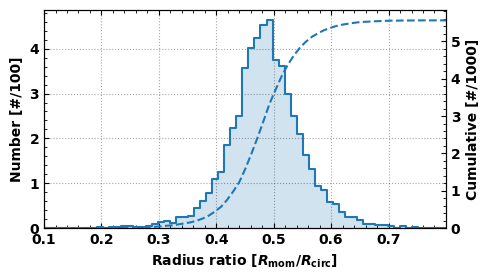

In [5]:
data1 = table['mean_sigma_pc'].value/table['radius_circ_pc'].value 
bins = np.linspace(np.nanmin([data1])*0.9, np.nanmax([data1])*1.1, 75)
bins1, bins_cent1, hist1 = get_hist(data1, bins=bins, norm=False)

fig = plt.figure(figsize=(5, 2.9)) 

ax = fig.add_subplot(111)

ax.plot(bins_cent1, hist1/100, ds='steps-mid')
ax.fill_between(bins_cent1, hist1/100, alpha=0.2, step='mid')

ylim = ax.get_ylim()
ax.set_ylim(0, ylim[-1])
ax.set_xlim(0.1, 0.8)

ax.set_xticks(np.arange(0.1,0.8,0.1))

ax.grid(True, alpha=0.35, ls=':', color='black')

ax.set_xlabel('Radius ratio [$R_\mathrm{mom}$/$R_\mathrm{circ}$]')
ax.set_ylabel('Number [#/100]')

ax2 = ax.twinx()
running_sum = np.cumsum(hist1)
ax2.plot(bins_cent1, running_sum/1000, ls='--', c='C0')
ylim = ax2.get_ylim()
ax2.set_ylim(0, ylim[-1])
ax2.set_ylabel('Cumulative [#/1000]')

fig.tight_layout(h_pad=0.5, w_pad=0.5)

plt.savefig('./figs/hist_radratio_sigma_all.pdf', dpi=250, bbox_inches='tight')

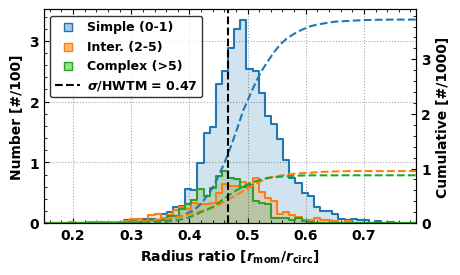

In [6]:
data1 = table['mean_sigma_pc'].value/table['radius_circ_pc'].value 
bins = np.linspace(np.nanmin([data1])*0.9, np.nanmax([data1])*1.1, 75)

fig = plt.figure(figsize=(5, 2.9)) 
ax = fig.add_subplot(111)
ax2 = ax.twinx()

for complexity_score in zip([0, 2, 5], [2, 5, 500]):

    data1 = table['mean_sigma_pc'].value/table['radius_circ_pc'].value 
    mask = (table['complexity_score'] >= complexity_score[0]) & (table['complexity_score'] < complexity_score[1])
    data1 = data1[mask]
    bins1, bins_cent1, hist1 = get_hist(data1, bins=bins, norm=False)

    ax.plot(bins_cent1, hist1/100, ds='steps-mid')
    ax.fill_between(bins_cent1, hist1/100, alpha=0.2, step='mid')

    running_sum = np.cumsum(hist1)
    ax2.plot(bins_cent1, running_sum/1000, ls='--')


ylim = ax.get_ylim()
ax.set_ylim(0, ylim[-1])
ax.set_xlim(0.15, 0.79)

ax.grid(True, alpha=0.35, ls=':', color='black')

ax.set_xlabel('Radius ratio [$r_\mathrm{mom}/r_\mathrm{circ}$]')
ax.set_ylabel('Number [#/100]')

ylim = ax2.get_ylim()
ax2.set_ylim(0, ylim[-1])
ax2.set_ylabel('Cumulative [#/1000]')

ax2.scatter(np.nan, np.nan, marker='s', ec=colors1[0], fc=colors2[0], label='Simple (0-1)')
ax2.scatter(np.nan, np.nan, marker='s', ec=colors1[1], fc=colors2[1], label='Inter. (2-5)')
ax2.scatter(np.nan, np.nan, marker='s', ec=colors1[2], fc=colors2[2], label='Complex (>5)')

ax2.plot([2/4.292, 2/4.292], [0, 1e4], ls='--', c='black', label='$\sigma$/HWTM = %0.2f' %(2/4.292))

ax2.legend(loc='upper left', edgecolor='black', handletextpad=0.5, fontsize=9)
fig.tight_layout(h_pad=0.5, w_pad=0.5)

plt.savefig('./figs/hist_radratio_sigma_complex.pdf', dpi=250, bbox_inches='tight')

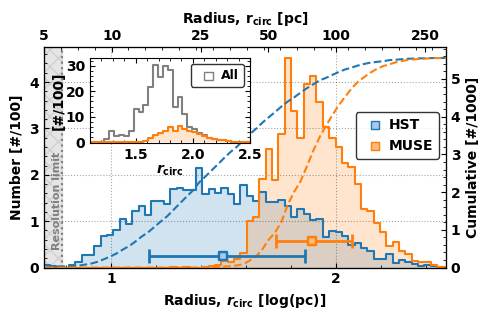

In [38]:
colors = mpl.cm.tab20(np.arange(0,20))
colors1 = colors[::2]
colors2 = colors[1::2]

data1 = np.log10(table['radius_circ_pc'].value)
data2 = np.log10(table['region_circ_rad_pc_MUSE'].value)
data3 = ((table_muse_masked['region_area']/np.pi)**0.5)*table_muse_masked['pc_per_pixel']
data3 = np.log10(data3.value)

bins = np.linspace(0.5, np.nanmax([data1,data2]), 75)

bins1, bins_cent1, hist1 = get_hist(data1, bins=bins, norm=False)
bins2, bins_cent2, hist2 = get_hist(data2, bins=bins, norm=False)
bins3, bins_cent3, hist3 = get_hist(data3, bins=bins, norm=False)

fig = plt.figure(figsize=(5, 3.3)) 

ax = fig.add_subplot(111)

ax.plot(bins_cent1, hist1/100, ds='steps-mid', c='C0')
ax.fill_between(bins_cent1, hist1/100, alpha=0.2, step='mid', fc='C0')
ax.scatter(np.nan, np.nan, marker='s', ec=colors1[0], fc=colors2[0], label='HST')

ax.plot(bins_cent2, hist2/100, ds='steps-mid', c='C1')
ax.fill_between(bins_cent2, hist2/100, alpha=0.2, step='mid', fc='C1')
ax.scatter(np.nan, np.nan, marker='s', ec=colors1[1], fc=colors2[1], label='MUSE')

ylim = ax.get_ylim()
ax.set_ylim(0, ylim[-1])
ax.set_xlim(0.7, 2.49)

ax.grid(True, alpha=0.35, ls=':', color='black')

ax.set_xlabel('Radius, $r_\mathrm{circ}$ [log(pc)]')
ax.set_ylabel('Number [#/100]')

ax2 = ax.twiny()
ax2.set_xlim(ax.get_xlim())
new_tick_locations = np.log10([5,10,25,50,100,250])
ax2.set_xticks(new_tick_locations)
ax2.set_xticklabels(np.round(np.power(10, new_tick_locations)).astype(int))
ax2.set_xlabel('Radius, r$_\mathrm{circ}$ [pc]')

ax.legend(loc='center right', edgecolor='black', handletextpad=0, bbox_to_anchor=(0.5, 0.35, 0.5, 0.5))

ax2 = ax.twinx()
running_sum = np.cumsum(hist1)
ax2.plot(bins_cent1, running_sum/1000, ls='--', c='C0')
running_sum = np.cumsum(hist2)
ax2.plot(bins_cent2, running_sum/1000, ls='--', c='C1')

ylim = ax2.get_ylim()
ax2.set_ylim(0, ylim[-1])
ax2.set_ylabel('Cumulative [#/1000]')


#### ---

bins = np.linspace(0.5, np.nanmax([data1,data2]), 50)

bins2, bins_cent2, hist2 = get_hist(data2, bins=bins, norm=False)
bins3, bins_cent3, hist3 = get_hist(data3, bins=bins, norm=False)

ax3 = fig.add_axes([0.19, 0.55, 0.32, 0.26])

ax3.plot(bins_cent3, hist3/100, ds='steps-mid', c='grey')
ax3.scatter(np.nan, np.nan, marker='s', ec='grey', fc='none', label='All')

ax3.plot(bins_cent2, hist2/100, ds='steps-mid', c='C1')
ax3.fill_between(bins_cent2, hist2/100, alpha=0.2, step='mid', fc='C1')
# ax3.scatter(np.nan, np.nan, marker='s', ec=colors1[1], fc=colors2[1], label='MUSE')

ax3.set_ylim(-0.5, np.nanmax(hist3/100)*1.1)
ax3.set_xlim(1.1, 2.5)

ax3.set_yticks([0,10,20,30])
ax2.set_xticks([1,2])

ax3.set_ylabel('[#/100]', labelpad=0)
ax3.set_xlabel('$r_\mathrm{circ}$', labelpad=0)

ax3.legend(loc='upper right', edgecolor='black', handletextpad=0, fontsize=9)
#### --- 

# plot medians
plot_median_with_percentile_error(ax2, data1, y=0.3, color1=colors1[0], color2=colors2[0])
plot_median_with_percentile_error(ax2, data2, y=0.7, color1=colors1[1], color2=colors2[1])

psf = 10
area_limit = np.sqrt((psf**2)/np.pi) #assumed a square area for psf... so making round here

ax.vlines(np.log10(6), 0, 1e4, ec='grey', ls=':', label='HST res.', zorder=-1)
ax.fill_between([-10, np.log10(6)], [0,0], [1e4,1e4], alpha=0.2, color='grey', hatch='XX', zorder=-1, edgecolor='grey', rasterized=True)
ax.text(np.log10(6), 2.5, 'Resolution limit', ha='right', va='top', color='grey', fontsize=8, rotation=90)

fig.tight_layout(h_pad=0.5, w_pad=0.5)

plt.savefig('./figs/hist_radlog_all.pdf', dpi=250, bbox_inches='tight', transparent=False)

In [8]:
"""Some tests comparing the area of the PSF to the area of the objects"""

# import numpy as np

# def gaussian_psf_area(theta_maj, theta_min):
#     """
#     Computes the area of a 2D Gaussian PSF.

#     Parameters:
#     theta_maj (float): FWHM along the major axis
#     theta_min (float): FWHM along the minor axis

#     Returns:
#     float: Area of the PSF
#     """
#     return (np.pi * theta_maj * theta_min) / (4 * np.log(2))

# # Example usage:
# theta_maj = 10  # Example major axis FWHM
# theta_min = 10  # Example minor axis FWHM
# area = gaussian_psf_area(theta_maj, theta_min)
# print(f"Gaussian PSF Area: {area}")
# print(f"Radius: {np.sqrt(area/np.pi)}")
# print(f"Area ratio compared to square area: {area/(theta_maj*theta_min)}")

# (3*theta_maj*theta_min/np.pi)**0.5

'Some tests comparing the area of the PSF to the area of the objects'

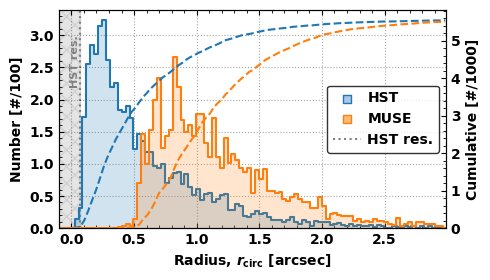

In [9]:
colors = mpl.cm.tab20(np.arange(0,20))
colors1 = colors[::2]
colors2 = colors[1::2]

data1 = table['radius_circ'].value
data2 = table['region_circ_rad_MUSE'].value

bins = np.linspace(-0.1, 3, 100)

bins1, bins_cent1, hist1 = get_hist(data1, bins=bins, norm=False)
bins2, bins_cent2, hist2 = get_hist(data2, bins=bins, norm=False)

fig = plt.figure(figsize=(5, 2.9)) 

ax = fig.add_subplot(111)

ax.plot(bins_cent1, hist1/100, ds='steps-mid', c='C0', zorder=2)
ax.fill_between(bins_cent1, hist1/100, alpha=0.2, step='mid', fc='C0', zorder=2)
ax.scatter(np.nan, np.nan, marker='s', ec=colors1[0], fc=colors2[0], label='HST')

ax.plot(bins_cent2, hist2/100, ds='steps-mid', c='C1', zorder=2)
ax.fill_between(bins_cent2, hist2/100, alpha=0.2, step='mid', fc='C1', zorder=2)
ax.scatter(np.nan, np.nan, marker='s', ec=colors1[1], fc=colors2[1], label='MUSE')

ylim = ax.get_ylim()
ax.set_ylim(0, ylim[-1])
ax.set_xlim(-0.1, 2.99)

ax.vlines(0.14/2., 0, 1e4, ec='grey', ls=':', label='HST res.', zorder=-1)
ax.fill_between([-10, 0.14/2.], [0,0], [1e4,1e4], alpha=0.2, color='grey', hatch='XX', zorder=-1, edgecolor='grey', rasterized=True)

ax.text(0.14/2., 3, 'HST res.', ha='right', va='top', color='grey', fontsize=8, rotation=90)

# ax.vlines([0.56/2., 1.25/2.], 0, 1e4, ec='C1', ls=':', label='MUSE psf.')

ax.grid(True, alpha=0.35, ls=':', color='black')

ax.set_xlabel('Radius, $r_\mathrm{circ}$ [arcsec]')
ax.set_ylabel('Number [#/100]')

ax2 = ax.twinx()
running_sum = np.cumsum(hist1)
ax2.plot(bins_cent1, running_sum/1000, ls='--', c='C0')
running_sum = np.cumsum(hist2)
ax2.plot(bins_cent2, running_sum/1000, ls='--', c='C1')

ylim = ax2.get_ylim()
ax2.set_ylim(0, ylim[-1])
ax2.set_ylabel('Cumulative [#/1000]')

ax.legend(loc='center right', edgecolor='black', handletextpad=0.5)

fig.tight_layout(h_pad=0.5, w_pad=0.5)

plt.savefig('./figs/hist_radlog_arcsec_all.pdf', dpi=250, bbox_inches='tight')

In [10]:
table_anderson = QTable.read('%s/data_misc/anderson_hiiregions/anderson14.fits' %root_dir)
mask = table_anderson['Dist'] == 0
table_anderson['Dist'][mask] = table_anderson['Dfar'][mask]
table_anderson = table_anderson[table_anderson['Dist'] != 0]
table_anderson['radius_pc'] = table_anderson['Rad']*(table_anderson['Dfar'].to('pc')/206265)

t_mcload21 = QTable.read('%s/data_misc/pressures_literature/McLeod2021_ngc300/McLeod2021_ngc300.fits'  %root_dir)

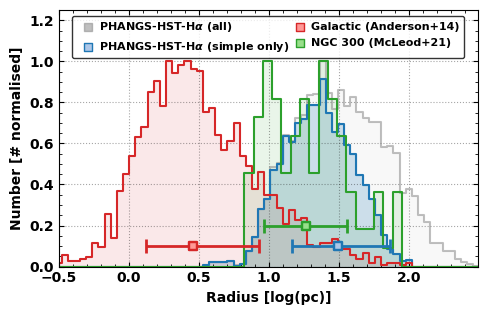

In [36]:
colors = mpl.cm.tab20(np.arange(0,20))
colors1 = colors[::2]
colors2 = colors[1::2]

data1 = np.log10(table['radius_circ_pc'].value)
data2 = np.log10(table_anderson['radius_pc'].value)
data3 = np.log10(t_mcload21['radius'].value)

data2 = data2[np.isfinite(data2)] 

mask_simple = table['complexity_score'] < 2
data4 = np.log10(table['radius_circ_pc'].value[mask_simple])

bins = np.linspace(-0.7, np.nanmax(data1), 75)
bins1, bins_cent1, hist1 = get_hist(data1, bins=bins, norm=False)
bins2, bins_cent2, hist2 = get_hist(data2, bins=bins, norm=False)
bins3, bins_cent3, hist3 = get_hist(data3, bins=np.linspace(-0.7, np.nanmax(data1), 50), norm=False)
bins4, bins_cent4, hist4 = get_hist(data4, bins=bins, norm=False)

hist1_max = np.max(hist1)
hist1 = hist1/hist1_max
hist2 = hist2/np.max(hist2)
hist3 = hist3/np.max(hist3)
hist4 = hist4/hist1_max

fig = plt.figure(figsize=(5, 3.25)) 
ax = fig.add_subplot(111)

ax.plot(bins_cent1, hist1, ds='steps-mid', c='grey', alpha=0.5)
ax.fill_between(bins_cent1, hist1, alpha=0.05, step='mid', fc='grey')
ax.scatter(np.nan, np.nan, marker='s', ec='grey', fc='grey', alpha=0.5, label=r'PHANGS-HST-H$\alpha$ (all)')

ax.plot(bins_cent4, hist4, ds='steps-mid', c='C0')
ax.fill_between(bins_cent4, hist4, alpha=0.2, step='mid', fc='C0', edgecolor='C0')
ax.scatter(np.nan, np.nan, marker='s', ec=colors1[0], fc=colors2[0], label=r'PHANGS-HST-H$\alpha$ (simple only)')

ax.plot(bins_cent2, hist2, ds='steps-mid', c='C3')
ax.fill_between(bins_cent2, hist2, alpha=0.1, step='mid', fc='C3')
ax.scatter(np.nan, np.nan, marker='s', ec=colors1[3], fc=colors2[3], label='Galactic (Anderson+14)')

ax.plot(bins_cent3, hist3, ds='steps-mid', c='C2')
ax.fill_between(bins_cent3, hist3, alpha=0.1, step='mid', fc='C2')
ax.scatter(np.nan, np.nan, marker='s', ec=colors1[2], fc=colors2[2], label='NGC 300 (McLeod+21)')

ylim = ax.get_ylim()
ax.set_ylim(0, 1.25)
ax.set_xlim(-0.5, 2.49)

ax.grid(True, alpha=0.35, ls=':', color='black')

ax.set_xlabel('Radius [log(pc)]')
ax.set_ylabel('Number [# normalised]')

ax.legend(loc='upper center', edgecolor='black', handletextpad=0, fontsize=8, ncol=2, columnspacing=0)

# plot medians
plot_median_with_percentile_error(ax, data1, y=0.1, color1=colors1[0], color2=colors2[0])
plot_median_with_percentile_error(ax, data2, y=0.1, color1=colors1[3], color2=colors2[3])
plot_median_with_percentile_error(ax, data3, y=0.2, color1=colors1[2], color2=colors2[2])

# ax2 = ax.twinx()
# running_sum = np.cumsum(hist1)
# ax2.plot(bins_cent1, running_sum/np.nanmax(running_sum), ls='--', c='C0')
# running_sum = np.cumsum(hist2)
# ax2.plot(bins_cent2, running_sum/np.nanmax(running_sum), ls='--', c='C2')
# running_sum = np.cumsum(hist3)
# ax2.plot(bins_cent3, running_sum/np.nanmax(running_sum), ls='--', c='C3')

# ylim = ax2.get_ylim()
# ax2.set_ylim(0, 1.25)
# ax2.set_ylabel('Cumulative [# normalised]')

fig.tight_layout(h_pad=0.5, w_pad=0.5)

plt.savefig('./figs/hist_radlog_literature_all.pdf', dpi=250, bbox_inches='tight')

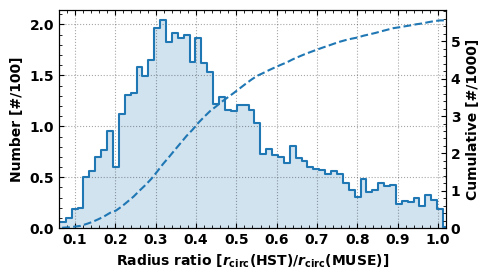

In [12]:
data1 = table['radius_circ_pc'].value/table['region_circ_rad_pc_MUSE'].value
bins = np.linspace(np.nanmin([data1])*0.9, np.nanmax([data1])*1.1, 75)
bins1, bins_cent1, hist1 = get_hist(data1, bins=bins, norm=False)

fig = plt.figure(figsize=(5, 2.9)) 
ax = fig.add_subplot(111)

ax.plot(bins_cent1, hist1/100, ds='steps-mid')
ax.fill_between(bins_cent1, hist1/100, alpha=0.2, step='mid')

ylim = ax.get_ylim()
ax.set_ylim(0, ylim[-1])
ax.set_xlim(0.06, 1.02)

ax.set_xticks(np.arange(0.1,1.1,0.1))

ax.grid(True, alpha=0.35, ls=':', color='black')

ax.set_xlabel('Radius ratio [$r_\mathrm{circ}(\mathrm{HST})/r_\mathrm{circ}(\mathrm{MUSE})$]')
ax.set_ylabel('Number [#/100]')

ax2 = ax.twinx()
running_sum = np.cumsum(hist1)
ax2.plot(bins_cent1, running_sum/1000, ls='--', c='C0')
ylim = ax2.get_ylim()
ax2.set_ylim(0, ylim[-1])
ax2.set_ylabel('Cumulative [#/1000]')

fig.tight_layout(h_pad=0.5, w_pad=0.5)

plt.savefig('./figs/hist_radratio_all.pdf', dpi=250, bbox_inches='tight')

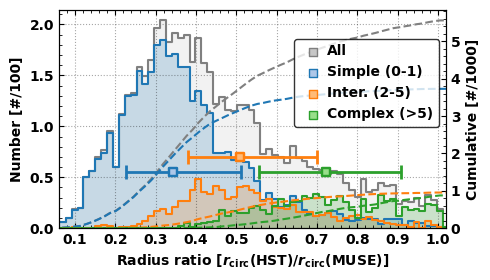

In [40]:
data1 = table['radius_circ_pc'].value/table['region_circ_rad_pc_MUSE'].value
bins = np.linspace(np.nanmin([data1])*0.9, np.nanmax([data1])*1.1, 75)
bins1a, bins_cent1, hist1 = get_hist(data1, bins=bins, norm=False)

fig = plt.figure(figsize=(5, 2.9)) 
ax = fig.add_subplot(111)
ax2 = ax.twinx()

ax.plot(bins_cent1, hist1/100, ds='steps-mid', color='grey')
ax.fill_between(bins_cent1, hist1/100, alpha=0.1, step='mid', color='grey')
running_sum = np.cumsum(hist1)
ax2.plot(bins_cent1, running_sum/1000, ls='--', c='grey')

for i, complexity_score in enumerate(zip([0, 2, 5], [2, 5, 500])):

    data1 = table['radius_circ_pc'].value/table['region_circ_rad_pc_MUSE'].value
    mask = (table['complexity_score'] >= complexity_score[0]) & (table['complexity_score'] < complexity_score[1])
    data1 = data1[mask]
    bins1, bins_cent1, hist1 = get_hist(data1, bins=bins, norm=False)

    ax.plot(bins_cent1, hist1/100, ds='steps-mid')
    ax.fill_between(bins_cent1, hist1/100, alpha=0.2, step='mid')

    running_sum = np.cumsum(hist1)
    ax2.plot(bins_cent1, running_sum/1000, ls='--')

    # plot medians
    if i == 2: 
        j = -i+2
    else: 
        j = i
    # plot medians
    plot_median_with_percentile_error(ax2, data1, y=1.5+(0.4*j), color1=colors1[i], color2=colors2[i])
    
ylim = ax.get_ylim()
ax.set_ylim(0, ylim[-1])
ax.set_xlim(0.06, 1.02)

ax.set_xticks(np.arange(0.1,1.1,0.1))

ax.grid(True, alpha=0.35, ls=':', color='black')

ax.set_xlabel('Radius ratio [$r_\mathrm{circ}(\mathrm{HST})/r_\mathrm{circ}(\mathrm{MUSE})$]')
ax.set_ylabel('Number [#/100]')

ylim = ax2.get_ylim()
ax2.set_ylim(0, ylim[-1])
ax2.set_ylabel('Cumulative [#/1000]')

ax2.scatter(np.nan, np.nan, marker='s', ec=colors1[7], fc=colors2[7], label='All')
ax2.scatter(np.nan, np.nan, marker='s', ec=colors1[0], fc=colors2[0], label='Simple (0-1)')
ax2.scatter(np.nan, np.nan, marker='s', ec=colors1[1], fc=colors2[1], label='Inter. (2-5)')
ax2.scatter(np.nan, np.nan, marker='s', ec=colors1[2], fc=colors2[2], label='Complex (>5)')
ax2.legend(loc='upper right', edgecolor='black', handletextpad=0, bbox_to_anchor=(0.5, 0.4, 0.5, 0.5))

fig.tight_layout(h_pad=0.5, w_pad=0.5)

plt.savefig('./figs/hist_radratio_complex.pdf', dpi=250, bbox_inches='tight')

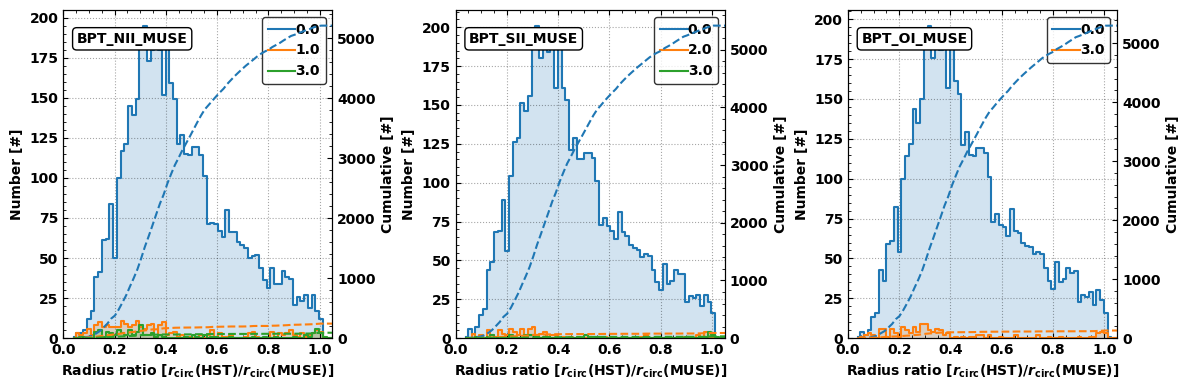

In [14]:
bpt_keys = ['BPT_NII_MUSE', 'BPT_SII_MUSE', 'BPT_OI_MUSE']

data1 = table['radius_circ_pc'].value/table['region_circ_rad_pc_MUSE'].value
bins = np.linspace(np.nanmin([data1])*0.9, np.nanmax([data1])*1.1, 75)

fig = plt.figure(figsize=(12, 4)) 

for i in range(3): 

    ax = fig.add_subplot(1,3,i+1)
    ax2 = ax.twinx()

    bpt_key = bpt_keys[i]
    bpt_data = table[bpt_key]
    bpt_values = np.unique(bpt_data).value
    bpt_values = bpt_values[bpt_values!=-1]

    for bpt_value in bpt_values:

        data1 = table['radius_circ_pc'].value/table['region_circ_rad_pc_MUSE'].value
        mask = bpt_data == bpt_value
        data1 = data1[mask]
        bins1, bins_cent1, hist1 = get_hist(data1, bins=bins, norm=False)

        ax.plot(bins_cent1, hist1, ds='steps-mid', label=bpt_value)
        ax.fill_between(bins_cent1, hist1, alpha=0.2, step='mid')

        running_sum = np.cumsum(hist1)
        ax2.plot(bins_cent1, running_sum, ls='--')

    ylim = ax.get_ylim()
    ax.set_ylim(0, ylim[-1])
    ax.set_xlim(0, 1.05)

    # ax.set_xticks(np.arange(0,1.1,0.1))

    ax.text(0.05, 0.9, bpt_key, transform=ax.transAxes, bbox=dict(facecolor='white', boxstyle='round', alpha=1))
    ax.grid(True, alpha=0.35, ls=':', color='black')

    ax.set_xlabel('Radius ratio [$r_\mathrm{circ}(\mathrm{HST})/r_\mathrm{circ}(\mathrm{MUSE})$]')
    ax.set_ylabel('Number [#]')

    ax.legend(loc='upper right', edgecolor='black', handletextpad=0)

    ylim = ax2.get_ylim()
    ax2.set_ylim(0, ylim[-1])
    ax2.set_ylabel('Cumulative [#]')

    # ax2.scatter(np.nan, np.nan, marker='s', ec=colors1[0], fc=colors2[0], label='Simple (0)')
    # ax2.scatter(np.nan, np.nan, marker='s', ec=colors1[1], fc=colors2[1], label='Simple (1-3)')
    # ax2.scatter(np.nan, np.nan, marker='s', ec=colors1[2], fc=colors2[2], label='Complex (>3)')
    # ax2.legend(loc='upper right', edgecolor='black', handletextpad=0)

fig.tight_layout(h_pad=0.5, w_pad=0.5)

# plt.savefig('./figs/hist_radratio_complex.pdf', dpi=250, bbox_inches='tight')

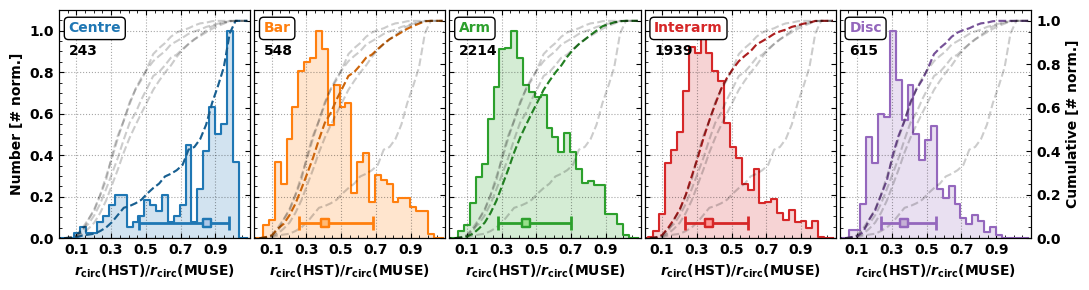

In [41]:
environments = [[1], [2,3], [5,6], [4,7,8], [9]]
environments_names = ['Centre', 'Bar', 'Arm', 'Interarm', 'Disc']
hist_all = []
running_sum_all = []

for i, environment in enumerate(environments):

    data_1 = table['radius_circ_pc'].value
    data_2 = table['region_circ_rad_pc_MUSE'].value

    mask_env = sum(([table['Environment_MUSE'] == env for env in environment])) == 1
    data_1_, data_2_ = data_1[mask_env], data_2[mask_env]
    data = data_1_/data_2_

    bins = np.linspace(-0.05, 1.1, 35)
    bins1, bins_cent1, hist1 = get_hist(data, bins=bins, norm=True)
    hist_all += [hist1]
    running_sum_all += [np.cumsum(hist1)]


fig = plt.figure(figsize=(11,3)) 
environments = [[1], [2,3], [5,6], [4,7,8], [9]]
environments_names = ['Centre', 'Bar', 'Arm', 'Interarm', 'Disc']

for i, environment in enumerate(environments):

    ax = fig.add_subplot(1,5,i+1)

    data_1 = table['radius_circ_pc'].value
    data_2 = table['region_circ_rad_pc_MUSE'].value

    mask_env = sum(([table['Environment_MUSE'] == env for env in environment])) == 1
    data_1_, data_2_ = data_1[mask_env], data_2[mask_env]
    data = data_1_/data_2_

    bins = np.linspace(-0.05, 1.1, 35)
    bins1, bins_cent1, hist1 = get_hist(data, bins=bins, norm=True)

    ax.plot(bins_cent1, hist1, ds='steps-mid', c='C%i'%i)
    ax.fill_between(bins_cent1, hist1, alpha=0.2, step='mid', fc='C%i'%i, ec='C%i'%i)
    ax.grid(True, alpha=0.35, ls=':', color='black')

    ax.text(0.05, 0.95, environments_names[i], ha='left', va='top', bbox=dict(facecolor='white', boxstyle='round', alpha=1), transform=ax.transAxes, color='C%i'%i)
    ax.text(0.05, 0.85, f"{len(data)}", transform=ax.transAxes, ha='left', va='top')

    ax.set_xticks(np.arange(0.1,1.1,0.2))
    ax.set_xlim(0, 1.1)
    ax.set_ylim(0, 1.1)
    ax.set_xlabel('$r_\mathrm{circ}(\mathrm{HST})/r_\mathrm{circ}(\mathrm{MUSE})$')

    ax2 = ax.twinx()
    running_sum = np.cumsum(hist1)
    ax2.plot(bins_cent1, running_sum/np.nanmax(running_sum), ls='--', c='C%i'%i)
    ylim = ax2.get_ylim()
    ax2.set_ylim(0, ylim[-1])

    for j in range(len(environments)):
        ax2.plot(bins_cent1, running_sum_all[j]/np.nanmax(running_sum_all[j]), c='black', alpha=0.2, ls='--')

    if i in [0]:
        ax.set_ylabel('Number [# norm.]')
    else:
        ax.set_yticklabels([])
    if i in [4]:
        ax2.set_ylabel('Cumulative [# norm.]')
    else:
        ax2.set_yticklabels([])

    # plot medians
    plot_median_with_percentile_error(ax2, data, y=0.07, color1=colors1[i], color2=colors2[i])

fig.tight_layout(h_pad=0.1, w_pad=0.1)
fig.subplots_adjust(wspace=0.02, hspace=0.02)

plt.savefig('./figs/hist_radratio_env.pdf', dpi=250, bbox_inches='tight')

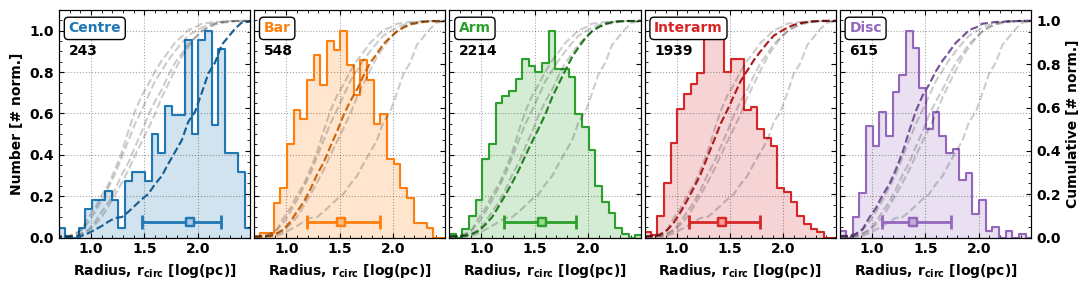

In [42]:
environments = [[1], [2,3], [5,6], [4,7,8], [9]]
environments_names = ['Centre', 'Bar', 'Arm', 'Interarm', 'Disc']
hist_all = []
running_sum_all = []

for i, environment in enumerate(environments):

    data_1 = np.log10(table['radius_circ_pc'].value)
    data_2 = np.ones(len(data_1))

    mask_env = sum(([table['Environment_MUSE'] == env for env in environment])) == 1
    data_1_, data_2_ = data_1[mask_env], data_2[mask_env]
    data = data_1_/data_2_

    bins = np.linspace(-0.05, 3, 50)
    bins1, bins_cent1, hist1 = get_hist(data, bins=bins, norm=True)
    hist_all += [hist1]
    running_sum_all += [np.cumsum(hist1)]


fig = plt.figure(figsize=(11,3)) 
environments = [[1], [2,3], [5,6], [4,7,8], [9]]
environments_names = ['Centre', 'Bar', 'Arm', 'Interarm', 'Disc']

for i, environment in enumerate(environments):

    ax = fig.add_subplot(1,5,i+1)

    data_1 = np.log10(table['radius_circ_pc'].value)
    data_2 = np.ones(len(data_1))

    mask_env = sum(([table['Environment_MUSE'] == env for env in environment])) == 1
    data_1_, data_2_ = data_1[mask_env], data_2[mask_env]
    data = data_1_/data_2_

    bins1, bins_cent1, hist1 = get_hist(data, bins=bins, norm=True)

    ax.plot(bins_cent1, hist1, ds='steps-mid', c='C%i'%i)
    ax.fill_between(bins_cent1, hist1, alpha=0.2, step='mid', fc='C%i'%i, ec='C%i'%i)
    ax.grid(True, alpha=0.35, ls=':', color='black')
    
    ax.text(0.05, 0.95, environments_names[i], ha='left', va='top', bbox=dict(facecolor='white', boxstyle='round', alpha=1), transform=ax.transAxes, color='C%i'%i)
    ax.text(0.05, 0.85, f"{len(data)}", transform=ax.transAxes, ha='left', va='top')

    # ax.set_xticks(np.arange(0.1,1.1,0.2))
    ax.set_xlim(0.7, 2.49)
    ax.set_ylim(0, 1.1)
    ax.set_xlabel('Radius, r$_\mathrm{circ}$ [log(pc)]')

    ax2 = ax.twinx()
    running_sum = np.cumsum(hist1)
    ax2.plot(bins_cent1, running_sum/np.nanmax(running_sum), ls='--', c='C%i'%i)
    ylim = ax2.get_ylim()
    ax2.set_ylim(0, ylim[-1])

    for j in range(len(environments)):
        ax2.plot(bins_cent1, running_sum_all[j]/np.nanmax(running_sum_all[j]), c='black', alpha=0.2, ls='--')

    if i in [0]:
        ax.set_ylabel('Number [# norm.]')
    else:
        ax.set_yticklabels([])
    if i in [4]:
        ax2.set_ylabel('Cumulative [# norm.]')
    else:
        ax2.set_yticklabels([])

    # plot medians
    plot_median_with_percentile_error(ax2, data, y=0.07, color1=colors1[i], color2=colors2[i])


fig.tight_layout(h_pad=0.1, w_pad=0.1)
fig.subplots_adjust(wspace=0.02, hspace=0.02)

plt.savefig('./figs/hist_rad_env.pdf', dpi=250, bbox_inches='tight')

In [17]:
import numpy as np
from scipy.stats import ks_2samp, kruskal

# Dictionary to store data for each environment
data_groups = {}

# Loop over environments to compute the ratio data
for i, environment in enumerate(environments):
    # Create a mask for the current environment(s)
    mask_env = sum([table['Environment_MUSE'] == env for env in environment]) == 1
    # Extract the relevant data
    data_1_ = table['radius_circ_pc'].value[mask_env]
    data_2_ = table['region_circ_rad_pc_MUSE'].value[mask_env]
    # Compute the ratio
    ratio_data = data_1_ / data_2_
    # Save the data using the environment name as key
    data_groups[environments_names[i]] = ratio_data

# Pairwise KS tests
print("Pairwise KS tests:")
ks_results = {}
env_names = list(data_groups.keys())
for i in range(len(env_names)):
    for j in range(i + 1, len(env_names)):
        env1, env2 = env_names[i], env_names[j]
        stat, p_value = ks_2samp(data_groups[env1], data_groups[env2])
        ks_results[(env1, env2)] = (stat, p_value)
        print(f"{env1} vs {env2}: KS statistic = {stat:.3f}, p-value = {p_value:.3f}")

# Overall test across all groups: Kruskal-Wallis test
group_data = [data_groups[name] for name in env_names]
kw_stat, kw_p_value = kruskal(*group_data)
print("\nKruskal-Wallis test across all environments:")
print(f"Statistic = {kw_stat:.3f}, p-value = {kw_p_value:.3f}")

Pairwise KS tests:
Centre vs Bar: KS statistic = 0.543, p-value = 0.000
Centre vs Arm: KS statistic = 0.536, p-value = 0.000
Centre vs Interarm: KS statistic = 0.599, p-value = 0.000
Centre vs Disc: KS statistic = 0.638, p-value = 0.000
Bar vs Arm: KS statistic = 0.080, p-value = 0.007
Bar vs Interarm: KS statistic = 0.117, p-value = 0.000
Bar vs Disc: KS statistic = 0.116, p-value = 0.001
Arm vs Interarm: KS statistic = 0.170, p-value = 0.000
Arm vs Disc: KS statistic = 0.170, p-value = 0.000
Interarm vs Disc: KS statistic = 0.042, p-value = 0.373

Kruskal-Wallis test across all environments:
Statistic = 471.654, p-value = 0.000


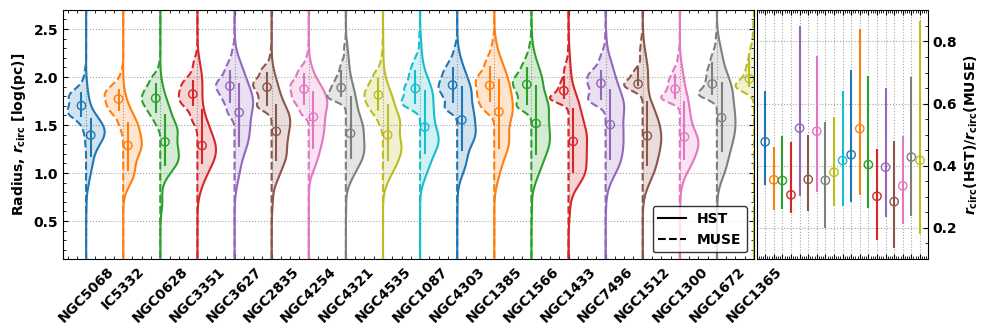

In [18]:
gal_names = table['gal_name'][np.unique(table['pc_per_pixel_MUSE'], return_index=True)[-1]]

data1 = np.log10(table['radius_circ_pc'].value)
data2 = np.log10(table['region_circ_rad_pc_MUSE'].value)

bins     = np.linspace(0.2, np.nanmax([data1,data2]), 50)
bins_kde = np.linspace(0, 3, 200)

fig = plt.figure(figsize=(10, 3.5)) 

ax = plt.subplot2grid((1, 5), (0, 0), rowspan=1, colspan=4)
ax2 = plt.subplot2grid((1, 5), (0, 4), rowspan=1, colspan=1)

# Rest of the code...

for i, gal_name in enumerate(gal_names):

    mask = table['gal_name'] == gal_name

    data1_masked = data1[mask]
    data2_masked = data2[mask]

    kde1 = stats.gaussian_kde(data1_masked)
    kde2 = stats.gaussian_kde(data2_masked)
    
    kde1_data = kde1(bins_kde)/np.nanmax(kde1(bins_kde))
    kde2_data = kde2(bins_kde)/np.nanmax(kde2(bins_kde))

    kde1_data = kde1_data+(i*2)
    kde2_data = (kde2_data*-1)+(i*2)

    ax.plot(kde1_data, bins_kde, c='C%i'%i)
    ax.plot(kde2_data, bins_kde, c='C%i'%i, ls='--')

    ax.fill_between(kde1_data, bins_kde, alpha=0.2, step='mid', fc='C%i'%i, ec='none', y2=0)
    ax.fill_between(kde2_data, bins_kde, alpha=0.2, step='mid', fc='C%i'%i, ec='none', y2=0)

    ax.scatter([(i*2)+0.25], [np.nanmedian(data1_masked)], ec='C%i'%i, fc='none')
    ax.scatter([(i*2)-0.25], [np.nanmedian(data2_masked)], ec='C%i'%i, fc='none')

    ax.errorbar([(i*2)+0.25], [np.nanmedian(data1_masked)], yerr=[[np.nanmedian(data1_masked)-np.nanpercentile(data1_masked, 16)], [np.nanpercentile(data1_masked, 84)-np.nanmedian(data1_masked)]], fmt='none', c='C%i'%i)
    ax.errorbar([(i*2)-0.25], [np.nanmedian(data2_masked)], yerr=[[np.nanmedian(data2_masked)-np.nanpercentile(data2_masked, 16)], [np.nanpercentile(data2_masked, 84)-np.nanmedian(data2_masked)]], fmt='none', c='C%i'%i)

ax.plot([0,0], [0,0], c='k', label='HST')
ax.plot([0,0], [0,0], c='k', ls='--', label='MUSE')

ax.legend(loc='lower right', edgecolor='black')

ax.set_ylim(0.1, 2.7)

# axa = ax.twinx()
# axa.set_ylim(ax.get_ylim())
# new_tick_locations = np.log10([2,5,10,25,50,100,250])
# axa.set_yticks(new_tick_locations)
# axa.set_yticklabels(np.round(np.power(10, new_tick_locations)).astype(int))

ax.set_ylabel('Radius, $r_\mathrm{circ}$ [log(pc)]')
# axa.set_ylabel('Radius [pc]')

ax.set_xlim(-1.25, 33.25)
ax.set_xticks(np.arange(0,len(gal_names)*2,2))
ax.set_xticklabels(gal_names, rotation=45, ha='center')

# axa = ax.twiny()
# axa.set_xlim(ax.get_xlim())
# new_tick_locations = np.arange(0,len(gal_names)*2,2)
# axa.set_xticks(new_tick_locations)
# axa.set_xticklabels(np.round(pc_per_pixel_MUSE.value))

# Add side panel plot
for i, gal_name in enumerate(gal_names):

    mask = table['gal_name'] == gal_name

    data1_masked = data1[mask]
    data2_masked = data2[mask]

    data = 10**(data1_masked-data2_masked)

    ax2.scatter([(i*2)], [np.nanmedian(data)], ec='C%i'%i, fc='none')
    ax2.errorbar([i*2], [np.nanmedian(data)], yerr=[[np.nanmedian(data)-np.nanpercentile(data, 16)], [np.nanpercentile(data, 84)-np.nanmedian(data)]], fmt='none', c='C%i'%i)

ax2.set_ylabel('$r_\mathrm{circ}(\mathrm{HST})/r_\mathrm{circ}(\mathrm{MUSE})$')
ax2.set_xticks(np.arange(0,len(gal_names)*2,2))
ax2.set_xticklabels([])
ax2.yaxis.set_ticks_position("right")
ax2.yaxis.set_label_position("right")

ax.grid(True, alpha=0.35, ls=':', color='black')
ax2.grid(True, alpha=0.35, ls=':', color='black')

fig.tight_layout(h_pad=0.5, w_pad=0.1)
fig.subplots_adjust(wspace=0.02, hspace=0.02)

plt.savefig('./figs/hist_radratio_gal.pdf', dpi=250, bbox_inches='tight')

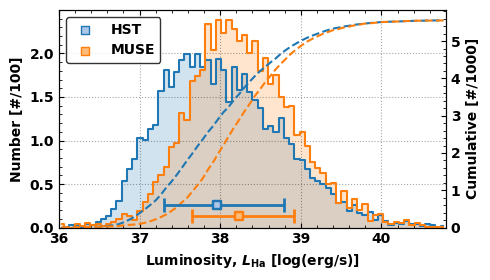

In [44]:
data1 = np.log10(np.array(table['HA6562_LUMINOSITY_HST'].value))
data2 = np.log10(np.array(table['HA6562_LUMINOSITY_MUSE'].value))

bins = np.linspace(36, 40.8, 75)

bins1, bins_cent1, hist1 = get_hist(data1, bins=bins, norm=False)
bins2, bins_cent2, hist2 = get_hist(data2, bins=bins, norm=False)

fig = plt.figure(figsize=(5, 2.9)) 

ax = fig.add_subplot(111)

ax.plot(bins_cent1, hist1/100, ds='steps-mid', c='C0')
ax.fill_between(bins_cent1, hist1/100, alpha=0.2, step='mid', fc='C0')
ax.scatter(np.nan, np.nan, marker='s', ec=colors1[0], fc=colors2[0], label='HST')

ax.plot(bins_cent2, hist2/100, ds='steps-mid', c='C1')
ax.fill_between(bins_cent2, hist2/100, alpha=0.2, step='mid', fc='C1')
ax.scatter(np.nan, np.nan, marker='s', ec=colors1[1], fc=colors2[1], label='MUSE')

ylim = ax.get_ylim()
ax.set_ylim(0, ylim[-1])
ax.set_xlim(np.percentile(bins, [0,100]))

ax.grid(True, alpha=0.35, ls=':', color='black')

ax.set_xlabel('Luminosity, $L_\mathrm{Ha}$ [log(erg/s)]')
ax.set_ylabel('Number [#/100]')

ax2 = ax.twinx()
running_sum = np.cumsum(hist1)
ax2.plot(bins_cent1, running_sum/1000, ls='--', c='C0')
running_sum = np.cumsum(hist2)
ax2.plot(bins_cent2, running_sum/1000, ls='--', c='C1')
ylim = ax2.get_ylim()
ax2.set_ylim(0, ylim[-1])
ax2.set_ylabel('Cumulative [#/1000]')

# plot medians
plot_median_with_percentile_error(ax2, data1, y=0.6, color1=colors1[0], color2=colors2[0])
plot_median_with_percentile_error(ax2, data2, y=0.3, color1=colors1[1], color2=colors2[1])
# 

fig.tight_layout(h_pad=0.5, w_pad=0.5)

ax.legend(loc='upper left', edgecolor='black')

plt.savefig('./figs/hist_lum_all.pdf', dpi=250, bbox_inches='tight')

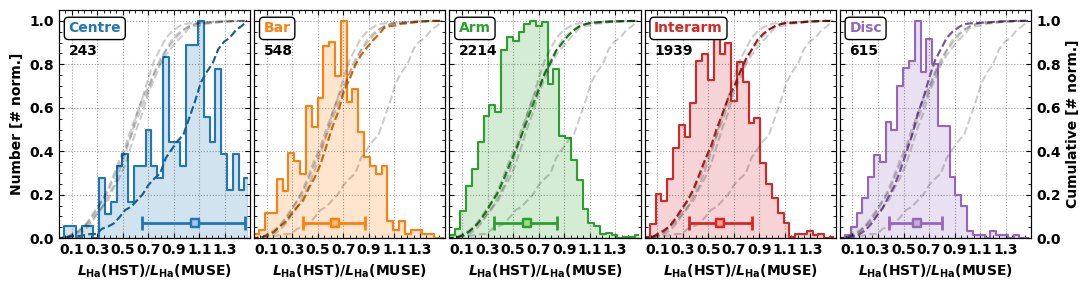

In [52]:
environments = [[1], [2,3], [5,6], [4,7,8], [9]]
environments_names = ['Centre', 'Bar', 'Arm', 'Interarm', 'Disc']
hist_all = []
running_sum_all = []

for i, environment in enumerate(environments):

    data_1 = np.array(table['HA6562_LUMINOSITY_HST'].value)
    data_2 = np.array(table['HA6562_LUMINOSITY_MUSE'].value)

    mask_env = sum(([table['Environment_MUSE'] == env for env in environment])) == 1
    data_1_, data_2_ = data_1[mask_env], data_2[mask_env]
    data = data_1_/data_2_

    bins = np.linspace(-0.05, 1.5, 35)
    bins1, bins_cent1, hist1 = get_hist(data, bins=bins, norm=True)
    hist_all += [hist1]
    running_sum_all += [np.cumsum(hist1)]

fig = plt.figure(figsize=(11,3)) 

# environments = np.unique(table['Environment'])
environments = [[1], [2,3], [5,6], [4,7,8], [9]]
environments_names = ['Centre', 'Bar', 'Arm', 'Interarm', 'Disc']

for i, environment in enumerate(environments):

    ax = fig.add_subplot(1,5,i+1)

    data_1 = np.array(table['HA6562_LUMINOSITY_HST'].value)
    data_2 = np.array(table['HA6562_LUMINOSITY_MUSE'].value)

    mask_env = sum(([table['Environment_MUSE'] == env for env in environment])) == 1
    data_1_, data_2_ = data_1[mask_env], data_2[mask_env]
    data = data_1_/data_2_

    bins = np.linspace(-0.05, 1.5, 35)
    bins1, bins_cent1, hist1 = get_hist(data, bins=bins, norm=True)

    ax.plot(bins_cent1, hist1, ds='steps-mid', c='C%i'%i)
    ax.fill_between(bins_cent1, hist1, alpha=0.2, step='mid', fc='C%i'%i, ec='C%i'%i)

    ax.grid(True, alpha=0.35, ls=':', color='black')

    ax.text(0.05, 0.95, environments_names[i], ha='left', va='top', bbox=dict(facecolor='white', boxstyle='round', alpha=1), transform=ax.transAxes, color='C%i'%i)
    ax.text(0.05, 0.85, f"{len(data)}", transform=ax.transAxes, ha='left', va='top')

    ax.set_xticks(np.arange(0.1,1.5,0.2))
    ax.set_xlim(0, 1.5)
    ax.set_ylim(0, 1.05)
    ax.set_xlabel('$L_\mathrm{Ha}(\mathrm{HST})/L_\mathrm{Ha}(\mathrm{MUSE})$')

    ax2 = ax.twinx()
    running_sum = np.cumsum(hist1)
    ax2.plot(bins_cent1, running_sum/np.nanmax(running_sum), ls='--', c='C%i'%i)    
    ylim = ax2.get_ylim()
    ax2.set_ylim(0, ylim[-1])

    for j in range(len(environments)):
        ax2.plot(bins_cent1, running_sum_all[j]/np.nanmax(running_sum_all[j]), c='black', alpha=0.2, ls='--')

    if i in [0]:
        ax.set_ylabel('Number [# norm.]')
    else:
        ax.set_yticklabels([])
    if i in [4]:
        ax2.set_ylabel('Cumulative [# norm.]')
    else:
        ax2.set_yticklabels([])

    # plot medians
    plot_median_with_percentile_error(ax2, data, y=0.07, color1=colors1[i], color2=colors2[i])
    # 

fig.tight_layout(h_pad=0.1, w_pad=0.1)
fig.subplots_adjust(wspace=0.02, hspace=0.02)

plt.savefig('./figs/hist_lumratio_env.pdf', dpi=250, bbox_inches='tight')

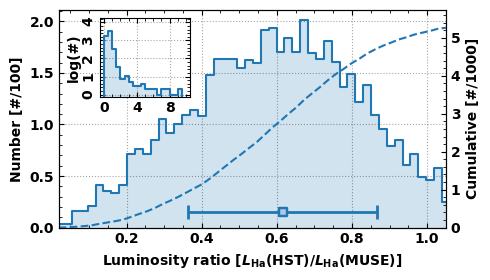

In [ ]:
data1 = table['HA6562_LUMINOSITY_HST'].value/table['HA6562_LUMINOSITY_MUSE'].value

bins = np.linspace(-0.05, 1.5, 75)

bins1, bins_cent1, hist1 = get_hist(data1, bins=bins, norm=False)

fig = plt.figure(figsize=(5, 2.9)) 

ax = fig.add_subplot(111)

ax.plot(bins_cent1, hist1/100, ds='steps-mid')
ax.fill_between(bins_cent1, hist1/100, alpha=0.2, step='mid')

ylim = ax.get_ylim()
ax.set_ylim(0, ylim[-1])
ax.set_xlim(0.02, 1.05)

# ax.set_xticks(np.arange(0,1.5,0.2))

ax.grid(True, alpha=0.35, ls=':', color='black')

ax.set_xlabel('Luminosity ratio [$L_\mathrm{Ha}(\mathrm{HST})/L_\mathrm{Ha}(\mathrm{MUSE})$]')
ax.set_ylabel('Number [#/100]')

ax2 = ax.twinx()
running_sum = np.cumsum(hist1)
ax2.plot(bins_cent1, running_sum/1000, ls='--', c='C0')
ylim = ax2.get_ylim()
ax2.set_ylim(0, ylim[-1])
ax2.set_ylabel('Cumulative [#/1000]')

# ax3 = fig.add_axes([0.67, 0.27, 0.22, 0.25])
ax3 = fig.add_axes([0.21, 0.65, 0.18, 0.27])

bins = np.linspace(-1, 11, 25)
bins1, bins_cent1, hist1 = get_hist(data1, bins=bins, norm=False)
hist1 = np.log10(hist1)
hist1[~np.isfinite(hist1)] = -100

ax3.plot(bins_cent1, hist1, ds='steps-mid')
ax3.fill_between(bins_cent1, hist1, y2=-10, alpha=0.2, step='mid')

ax3.set_ylim(-0.1, np.nanmax(hist1)*1.2)
ax3.set_xlim(-0.5, 10.5)
ax3.grid(True, alpha=0.35, ls=':', color='black')

ax3.set_ylabel('log(#)', labelpad=0)

ax3.set_yticks([0, 1, 2, 3, 4]) 
ax3.set_xticks([0, 4, 8])

# medians
plot_median_with_percentile_error(ax2, data1, y=0.4, color1=colors1[0], color2=colors2[0])

for tick in ax3.get_yticklabels():
    tick.set_rotation(90)

fig.tight_layout(h_pad=0.5, w_pad=0.5)

plt.savefig('./figs/hist_lumratio_all.pdf', dpi=250, bbox_inches='tight')

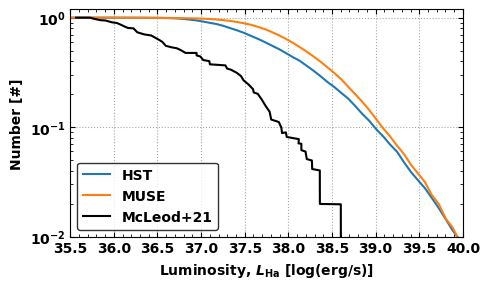

In [22]:
cumulative1_m21 = QTable.read('/Users/abarnes/Dropbox/work/Smallprojects/galaxies/data_misc/pressures_literature/McLeod2021_ngc300/McLeod2021_ngc300_cumdist.csv', format='ascii.csv', data_start=1)
cumulative1_m21['number'] = 10**cumulative1_m21['number']

cumulative1_m21['number'] = (cumulative1_m21['number']/np.nanmax(cumulative1_m21['number'])) 

data1 = np.log10(np.array(table['HA6562_LUMINOSITY_HST'].value))
data2 = np.log10(np.array(table['HA6562_LUMINOSITY_MUSE'].value))

bins = np.linspace(34.9, 40.8, 75)
bins1, bins_cent1, hist1 = get_hist(data1, bins=bins, norm=False)
bins2, bins_cent2, hist2 = get_hist(data2, bins=bins, norm=False)

running_sum1 = np.cumsum(hist1)
running_sum2 = np.cumsum(hist2)

cumulative1 = (np.nanmax(running_sum1) - running_sum1)/np.nanmax(running_sum1)
cumulative2 = (np.nanmax(running_sum1) - running_sum2)/np.nanmax(running_sum2)

# cumulative1 = (np.nanmax(running_sum1) - running_sum1)
# cumulative2 = (np.nanmax(running_sum1) - running_sum2)

fig = plt.figure(figsize=(5, 3)) 
ax = fig.add_subplot(111)

ax.plot(bins_cent1, cumulative1, ls='-', c='C0', label='HST')
ax.plot(bins_cent2, cumulative2, ls='-', c='C1', label='MUSE')
ax.plot(cumulative1_m21['Lum'], cumulative1_m21['number'], ls='-', c='black', label='McLeod+21')

ax.set_yscale('log')
ax.set_ylim(1e-2, 1.2)
ax.set_xlim(35.5, 40)

ax.grid(True, alpha=0.35, ls=':', color='black')
ax.set_xlabel('Luminosity, $L_\mathrm{Ha}$ [log(erg/s)]')
ax.set_ylabel('Number [#]')
fig.tight_layout(h_pad=0.5, w_pad=0.5)

ax.legend(loc='lower left', edgecolor='black')

# plt.savefig('./figs/hist_lum_all.pdf', dpi=250, bbox_inches='tight')

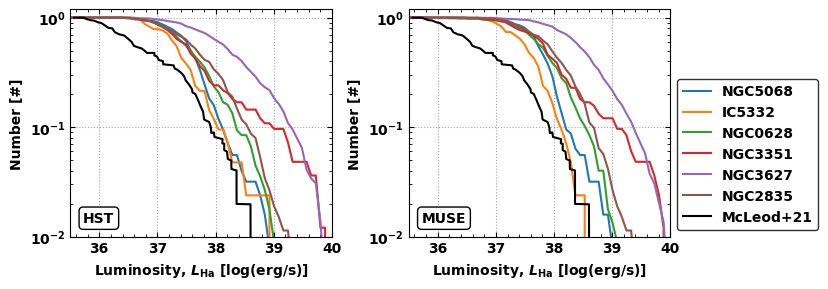

In [23]:
cumulative1_m21 = QTable.read('/Users/abarnes/Dropbox/work/Smallprojects/galaxies/data_misc/pressures_literature/McLeod2021_ngc300/McLeod2021_ngc300_cumdist.csv', format='ascii.csv', data_start=1)
cumulative1_m21['number'] = 10**cumulative1_m21['number']

cumulative1_m21['number'] = (cumulative1_m21['number']/np.nanmax(cumulative1_m21['number'])) 

data1 = np.log10(np.array(table['HA6562_LUMINOSITY_HST'].value))
data2 = np.log10(np.array(table['HA6562_LUMINOSITY_MUSE'].value))

bins = np.linspace(34.9, 40.8, 75)
fig = plt.figure(figsize=(7, 3)) 
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

for i, gal_name in enumerate(gal_names):

    if i > 5: 
        continue

    mask = table['gal_name'] == gal_name

    data1_masked = data1[mask]
    data2_masked = data2[mask]

    bins1, bins_cent1, hist1 = get_hist(data1_masked, bins=bins, norm=False)
    bins2, bins_cent2, hist2 = get_hist(data2_masked, bins=bins, norm=False)

    running_sum1 = np.cumsum(hist1)
    running_sum2 = np.cumsum(hist2)

    cumulative1 = (np.nanmax(running_sum1) - running_sum1)/np.nanmax(running_sum1)
    cumulative2 = (np.nanmax(running_sum1) - running_sum2)/np.nanmax(running_sum2)

    ax1.plot(bins_cent1, cumulative1, ls='-', c='C%i' %i, label='%s' %gal_name)
    ax2.plot(bins_cent2, cumulative2, ls='-', c='C%i' %i, label='%s' %gal_name)

ax1.plot(cumulative1_m21['Lum'], cumulative1_m21['number'], ls='-', c='black', label='McLeod+21')
ax2.plot(cumulative1_m21['Lum'], cumulative1_m21['number'], ls='-', c='black', label='McLeod+21')

ax1.text(0.05, 0.05, 'HST', ha='left', va='bottom', bbox=dict(facecolor='white', boxstyle='round', alpha=1), transform=ax1.transAxes, color='black')
ax2.text(0.05, 0.05, 'MUSE', ha='left', va='bottom', bbox=dict(facecolor='white', boxstyle='round', alpha=1), transform=ax2.transAxes, color='black')

for ax in [ax1, ax2]: 

    ax.set_yscale('log')
    ax.set_ylim(1e-2, 1.2)
    ax.set_xlim(35.5, 40)

    ax.grid(True, alpha=0.35, ls=':', color='black')
    ax.set_xlabel('Luminosity, $L_\mathrm{Ha}$ [log(erg/s)]')
    ax.set_ylabel('Number [#]')

fig.tight_layout(h_pad=0.5, w_pad=0.5)

ax.legend(loc='lower left', edgecolor='black', bbox_to_anchor=(1, 0))

# plt.savefig('./figs/hist_lum_all.pdf', dpi=250, bbox_inches='tight')

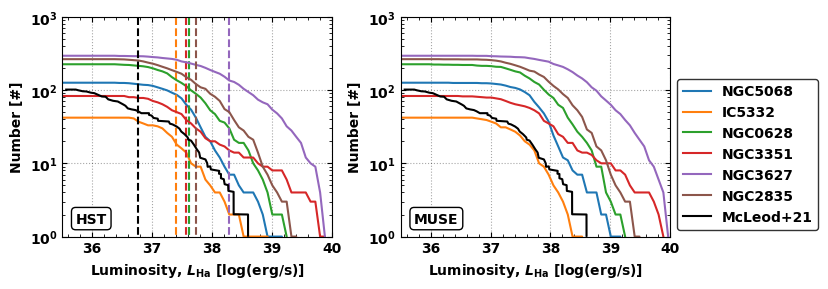

In [24]:
cumulative1_m21 = QTable.read('/Users/abarnes/Dropbox/work/Smallprojects/galaxies/data_misc/pressures_literature/McLeod2021_ngc300/McLeod2021_ngc300_cumdist.csv', format='ascii.csv', data_start=1)
cumulative1_m21['number'] = 10**cumulative1_m21['number']

# cumulative1_m21['number'] = (cumulative1_m21['number']/np.nanmax(cumulative1_m21['number'])) 

data1 = np.log10(np.array(table['HA6562_LUMINOSITY_HST'].value))
data2 = np.log10(np.array(table['HA6562_LUMINOSITY_MUSE'].value))

bins = np.linspace(34.9, 40.8, 75)
fig = plt.figure(figsize=(7, 3)) 
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

for i, gal_name in enumerate(gal_names):

    if i > 5: 
        continue

    mask = table['gal_name'] == gal_name

    data1_masked = data1[mask]
    data2_masked = data2[mask]

    bins1, bins_cent1, hist1 = get_hist(data1_masked, bins=bins, norm=False)
    bins2, bins_cent2, hist2 = get_hist(data2_masked, bins=bins, norm=False)

    running_sum1 = np.cumsum(hist1)
    running_sum2 = np.cumsum(hist2)

    cumulative1 = (np.nanmax(running_sum1) - running_sum1)
    cumulative2 = (np.nanmax(running_sum1) - running_sum2)

    ax1.plot(bins_cent1, cumulative1, ls='-', c='C%i' %i, label='%s' %gal_name)
    ax2.plot(bins_cent2, cumulative2, ls='-', c='C%i' %i, label='%s' %gal_name)

    ax1.plot([np.median(data1_masked)]*2, [0,1e5], ls='--', c='C%i' %i)

ax1.plot(cumulative1_m21['Lum'], cumulative1_m21['number'], ls='-', c='black', label='McLeod+21')
ax2.plot(cumulative1_m21['Lum'], cumulative1_m21['number'], ls='-', c='black', label='McLeod+21')
ax1.plot([cumulative1_m21['Lum'][20]]*2, [0,1e5], ls='--', c='black')


ax1.text(0.05, 0.05, 'HST', ha='left', va='bottom', bbox=dict(facecolor='white', boxstyle='round', alpha=1), transform=ax1.transAxes, color='black')
ax2.text(0.05, 0.05, 'MUSE', ha='left', va='bottom', bbox=dict(facecolor='white', boxstyle='round', alpha=1), transform=ax2.transAxes, color='black')

for ax in [ax1, ax2]: 

    ax.set_yscale('log')
    ax.set_ylim(1, 1e3)
    ax.set_xlim(35.5, 40)

    ax.grid(True, alpha=0.35, ls=':', color='black')
    ax.set_xlabel('Luminosity, $L_\mathrm{Ha}$ [log(erg/s)]')
    ax.set_ylabel('Number [#]')

fig.tight_layout(h_pad=0.5, w_pad=0.5)

ax.legend(loc='lower left', edgecolor='black', bbox_to_anchor=(1, 0))

# plt.savefig('./figs/hist_lum_all.pdf', dpi=250, bbox_inches='tight')